In [3]:
import numpy as np
import scipy.integrate
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt, rc
from astropy import units as u

# we don't care about the error estimates
def numint(*args):
    return scipy.integrate.quad(*args)[0]

In [4]:
rc('figure', figsize=(12,8))
rc('font', size=18)
rc('lines', linewidth=3)
rc('axes', linewidth=2)
rc('xtick.major', width=2)
rc('ytick.major', width=2)
rc('text', usetex=False)

#matplotlib.rcParams

In [5]:
Wm = 0.3
Wde = 0.7
#h = 0.72
# leave h out of calculation so results are independent of it
h = u.def_unit(['h', 'dimensionless_hubble'])
H0 = (100 * u.km / u.megaparsec / u.second).decompose() * h
c = 3e8 * u.m / u.second

Wr = 4.22e-5 * (1/h**2)

## Comoving distance

$$x(z)=\int_0^z\frac{\mathrm{d}\,z'}{E(z')}$$

with $E(z)=\left[\Omega_m(1+z)^3+\Omega_\Lambda\right]^{1/2}$

In [6]:
def E(z):
    return np.sqrt(Wm * (1 + z)**3 + Wde)

def cmdist(z):
    func = lambda z: 1 / E(z)
    return (c / H0) * np.array([numint(func, 0, zval) for zval in z])

In [7]:
redshifts = np.geomspace(0.01, 10, 1000)

comoving_dists = cmdist(redshifts)

## Angular diameter distance

In [8]:
def addist(z):
    return cmdist(z) / (1 + z)

ang_dim_dists = addist(redshifts)

## Luminosity distance

In [9]:
def lumdist(z):
    return (1 + z)**2 * addist(z)

lum_dists = lumdist(redshifts)

## Age of the Universe

In [10]:
def t(z):
    func = lambda z: 1 / ((1 + z) * E(z))
    return (1 / H0) * np.array([numint(func, zval, np.inf) for zval in z])

ages = t(redshifts)

In [11]:
print((t([0]) * (h/0.72)).to(u.gigayear))

[ 13.09290106] Gyr


## Physical distance

In [12]:
def phydist(z):
    func = lambda z: 1 / ((z + 1) * E(z))
    return (c / H0) * np.array([numint(func, 0, zval) for zval in z])

physical_dists = phydist(redshifts)

## Plot for Q1

Max angular diameter distance: 1.22 Gpc / h
Max redshift is: 1.6003103137387


/home/calvin/.local/lib/python3.5/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


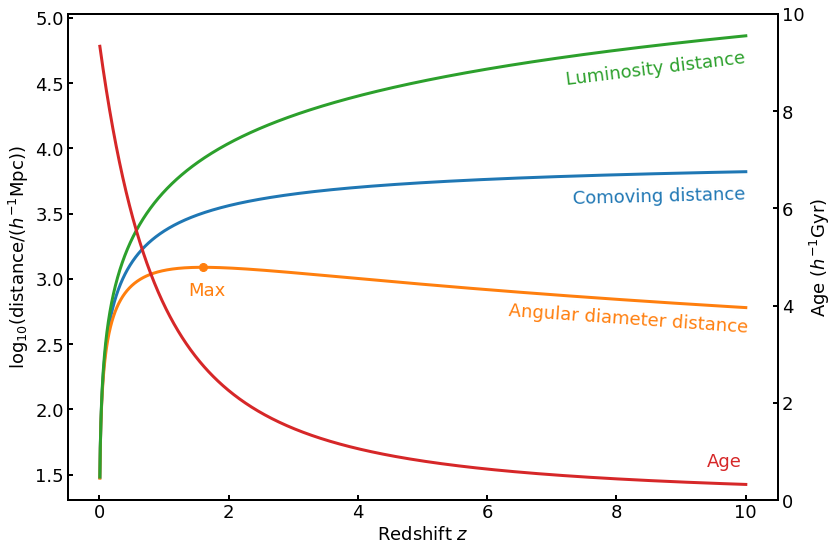

In [13]:
# maximum angular diameter distance
max_loc = np.argmax(ang_dim_dists)
max_ang_dim_dist = ang_dim_dists[max_loc]
max_ang_dim_z = redshifts[max_loc]

fig = plt.figure()
ax = plt.gca()
ax.tick_params(axis='both', direction='in', length=5)
ax.set_xlabel(r'Redshift $z$')
ax.set_ylabel(r'$\log_{10}(\mathrm{distance}/(h^{-1}\mathrm{Mpc}))$')
# Comoving distance
ax.plot(redshifts, np.log10(comoving_dists * h / u.megaparsec))
ax.annotate('Comoving distance', xy=(0.71, 0.62), xycoords='axes fraction', rotation=1.5, color='tab:blue')
# Ang dim distance
ax.plot(redshifts, np.log10(ang_dim_dists * h / u.megaparsec))
ax.annotate('Angular diameter distance', xy=(0.62, 0.38), xycoords='axes fraction', rotation=-4, color='tab:orange')
ax.scatter(max_ang_dim_z, np.log10(max_ang_dim_dist * h / u.megaparsec), 64, c='tab:orange')
ax.annotate('Max', xy=(0.17, 0.42), xycoords='axes fraction', color='tab:orange')
#Luminosity distance
ax.plot(redshifts, np.log10(lum_dists * h / u.megaparsec))
ax.annotate('Luminosity distance', xy=(0.7, 0.9), xycoords='axes fraction', rotation=7, color='tab:green')
# Physical distances
#ax.plot(redshifts, np.log10(physical_dists * h / u.megaparsec))

ax2 = ax.twinx()
ax2.set_ylim(0, 10)
ax2.tick_params(axis='both', direction='in', length=5)
ax2.set_ylabel(r'Age ($h^{-1}\mathrm{Gyr}$)')
ax2.plot(redshifts, (ages * h).to(u.gigayear), label='Age', c='tab:red')
ax.annotate('Age', xy=(0.9, 0.07), xycoords='axes fraction', color='tab:red')

print('Max angular diameter distance: {:.3g}'.format(max_ang_dim_dist.to(u.gigaparsec / h)))
print('Max redshift is: {}'.format(max_ang_dim_z))
fig.set_tight_layout(True)
plt.savefig('q1_plot.pdf')

## Age of stars formed at z=4 when z=3

In [14]:
t_z4z3 = t([4, 3])

age_stars = np.diff(t_z4z3).squeeze()
print('Stars are {:.3g} old at z=3'.format(age_stars.to(u.megayear / h)))

Stars are 418 Myr / h old at z=3


## Redshifts when filter detects Ly $\alpha$

In [15]:
def z(wl_o, wl_e):
    return wl_o / wl_e - 1

lambda_emitted = 1215.67 * u.angstrom
lambda_observed = 4862.24 * u.angstrom
delta_lambda_half = 15 * u.angstrom

redshift_range = np.array([z(lambda_observed - delta_lambda_half, lambda_emitted),
                  z(lambda_observed + delta_lambda_half, lambda_emitted)])

## Projected size of telescope field at these redshifts

In [16]:
telescope_field = 5 * u.arcminute

proj_size_range = (telescope_field * addist(redshift_range)).to(u.megaparsec / h, equivalencies=u.dimensionless_angles())

# little variation so take average and treat volume as cuboidal
proj_size_avg = np.mean(proj_size_range)

## Comoving and physical survey volumes

In [17]:
delta_comoving_dist = np.diff(cmdist(redshift_range)).squeeze().to(u.megaparsec / h)

comoving_volume = proj_size_avg**2 * delta_comoving_dist

delta_physical_dist = np.diff(phydist(redshift_range)).squeeze().to(u.megaparsec / h)

physical_volume = proj_size_avg**2 * delta_physical_dist

print('Surveyed comoving volume is {:.3g}'.format(comoving_volume))
print('Surveyed physical volume is {:.3g}'.format(physical_volume))

Surveyed comoving volume is 43.5 Mpc3 / h3
Surveyed physical volume is 10.9 Mpc3 / h3


In [19]:
Msun = 5.48 # in B band
S_mag_asec2 = 28

S_phys_units = 10**((Msun+21.572 - S_mag_asec2) / 2.5)

Ie_phys_units = 4 * np.pi * 4**4 * S_phys_units
Ie_mag_asec2 = Msun + 21.572 - 2.5 * np.log10(Ie_phys_units)

print(Ie_mag_asec2)

19.2313754267
